## Federated Quasi Newton Learn
Here is proposed a version of the Federated Newton Learn algorithm combined with some of the ideas behind the quasi Newton method.

In [1]:
from ipyparallel import Client
c = Client()
c.ids

[0, 1]

In [2]:
%%px
import tensorflow as tf
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from numsa.TFHessian import *
import dsdl
from copy import copy

comm = MPI.COMM_WORLD

ds = dsdl.load("a1a")

X, Y = ds.get_train()
indx = np.array_split(range(X.shape[0]),int(comm.Get_size()));
tfX = []
tfY = []
for k in range(len(indx)):
    tfX = tfX + [tf.sparse.from_dense(np.array(X[indx[comm.Get_rank()]].todense(), dtype=np.float32))]
    tfY = tfY + [tf.convert_to_tensor(np.array(Y[indx[comm.Get_rank()]], dtype=np.float32).reshape(X[indx[comm.Get_rank()]].shape[0], 1))]

tfXs = tf.sparse.from_dense(np.array(X.todense(), dtype=np.float32))
tfYs = tf.convert_to_tensor(np.array(Y, dtype=np.float32).reshape(X.shape[0], 1))
#Defining the Loss Function
def LossSerial(x):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfXs, x, adjoint_a=False)
    Z = tf.math.multiply(tfYs, Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfXs.shape[0]) + lam*tf.norm(x)**2

    return S
#Defining the Loss Function
def Loss(x,comm):
    lam = 1e-3; #Regularisation
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfX[comm.Get_rank()], x, adjoint_a=False)
    Z = tf.math.multiply(tfY[comm.Get_rank()], Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfX[comm.Get_rank()].shape[0]) + lam*tf.norm(x)**2
    return S
################! Setting Of The Solver!##################
itmax = 1000
tol = 1e-4;
step_size=1;
N = 119;
###########################################################
Residuals = [];
x = tf.Variable(0.1*np.ones((119,1),dtype=np.float32))

H = Hessian(Loss,x);
H.shift(x, opt={"type":"act"})
#We now collect and average the loc Hessians in the master node (rk 0)
QInv = np.identity(N);

#print("The master Hessian has been initialised")
for it in tqdm(range(itmax)):
    # Obtaining the compression of the difference between local mat
    # and next local mat.
    U,sigma,Vt = H.shift(x,{"comp":ActHalko,"rk":1,"type":"act"});
    #print("Updating local Hessian")
    H.memH = copy(H.vecprod);
    grad = H.grad().numpy();
    #Now we update the master Hessian and perform the Newton method step
    ShiftUs = H.comm.gather(U, root=0);
    ShiftVs = H.comm.gather(sigma[0]*Vt, root=0);
    Grads = H.comm.gather(grad, root=0);
    if H.comm.Get_rank() == 0:
        #print("Computing the avarage of the local shifts and grad ...")
        u = (1/len(ShiftUs))*np.sum(ShiftUs,0);
        v = (1/len(ShiftVs))*np.sum(ShiftVs,0);
        Grad = (1/len(Grads))*np.sum(Grads,0);
        res = np.linalg.norm(Grad);
        Residuals = Residuals + [res];
        #print("Computing the master Hessian ...")
        #SHERMAN-MORRISON
        normal = (1+v@QInv@u);
        #print("Normalisation: ",normal);
        A = QInv@u@v@QInv;
        #print("A Shape: ",A.shape)
        QInv = QInv - (1/(1+normal))*A;
        #print("Searching new search direction ...")
        q =  QInv@Grad;
        #print("Found search dir, ",q.shape);
        if it%250 == 0:
            print("(FedNL) [Iteration. {}] Lost funciton at this iteration {}  and gradient norm {}".format(it,LossSerial(x),np.linalg.norm(Grad)));
        x = x - tf.Variable(q,dtype=np.float32);
        x =  tf.Variable(x)
    else:
        res = None
    #Distributing the search direction
    x = H.comm.bcast(x,root=0)
    res = H.comm.bcast(res,root=0)
    if res<tol:
            break
LossStar =  0.33691510558128357;
print("Lost funciton at this iteration {}, gradient norm {} and error {}.".format(LossSerial(x),np.linalg.norm(grad),abs(LossSerial(x)-LossStar)))

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:1] 100%|██████████| 1000/1000 [02:13<00:00,  7.50it/s]


[stderr:0] 100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


[stdout:0] (FedNL) [Iteration. 0] Lost funciton at this iteration 1.2675940990447998  and gradient norm 1.388305902481079
(FedNL) [Iteration. 250] Lost funciton at this iteration 0.33855322003364563  and gradient norm 0.0034793473314493895
(FedNL) [Iteration. 500] Lost funciton at this iteration 0.33725541830062866  and gradient norm 0.0013742920709773898
(FedNL) [Iteration. 750] Lost funciton at this iteration 0.33700743317604065  and gradient norm 0.000675040006171912
Lost funciton at this iteration 0.33694300055503845, gradient norm 0.020190397277474403 and error 2.7894973754882812e-05.


[stdout:1] Lost funciton at this iteration 0.33694300055503845, gradient norm 0.020146865397691727 and error 2.7894973754882812e-05.


Text(0.5, 1.0, 'Residual Decay')

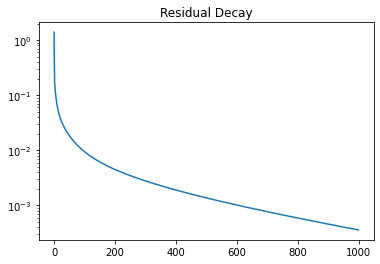

In [3]:
import matplotlib.pyplot as plt
Rs = c[:]["Residuals"][0]
plt.semilogy(range(len(Rs)),Rs)
plt.title("Residual Decay")